# Starbucks Capstone Challenge

## 1. Project Definition

### Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Problem Statement

The problem is combining transaction data, demographics, and bidding data to determine which demographic groups best respond to which type of bidding.

### Metrics

The metrics to be used are descriptive statistics measures, such as the mean, median, percentiles and logistic regression models such as the hypothesis tests of each variable and the accuracy criterion.

## 2. Descriptive and exploratory analysis


### Library and Import database

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import json
import re
import os
import datetime
from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import norm

# Setting matplotlib
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"

In [2]:
# read in the json files
portfolio = pd.read_json('C:/Users/Teletrabajo/Desktop/1.UDACITY/Final/starbucks-capstone-challenge-master/Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('C:/Users/Teletrabajo/Desktop/1.UDACITY/Final/starbucks-capstone-challenge-master/Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('C:/Users/Teletrabajo/Desktop/1.UDACITY/Final/starbucks-capstone-challenge-master/Data/transcript.json', orient='records', lines=True)

### 2.1 Portfolio Data 

Containing offer ids and meta data about each offer (duration, type, etc.):

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

The following reflects that there are 10 different types of id, with 3 types of offer: BOGO, discount, informational, which communicate with different channels such as web, email, mobile and social. 

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.shape

(10, 6)

In [5]:
grouped_dataportfolio = portfolio.groupby('offer_type')
# Returns the average of each numerical column by type of offer. 
grouped_dataportfolio.mean()

,reward,difficulty,duration
offer_type,,,
bogo,7.5,7.50,6.0
discount,3.0,11.75,8.5
informational,0.0,0.00,3.5


It was found that the discount offer type has the highest minimum required to spend to complete an offer, that the offer with the shortest duration is informational and that the highest reward amount is given to BOGO type offers.

### 2.2 Profile Data

This database contains the demographic data of each client, with the following information:

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**The following is an analysis of the variables in the database whats contains data from 17,000 customers:**

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.shape

(17000, 5)

### Null value analysis

In [8]:
print(profile.isnull().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


**It is evident that there are 2,175 clients with null values in the gender and income columns.**

### Gender Description

In [9]:
gender_counts = profile.groupby('gender')['id'].count()
print(gender_counts)
print('# customers =',gender_counts.sum())

gender
F    6129
M    8484
O     212
Name: id, dtype: int64
# customers = 14825


In [10]:
print(gender_counts/gender_counts.sum())

gender
F    0.413423
M    0.572277
O    0.014300
Name: id, dtype: float64


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

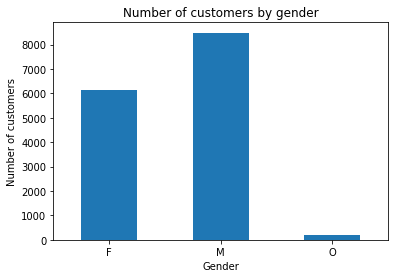

In [11]:
gender_counts.plot(kind='bar')
plt.title('Number of customers by gender')
plt.ylabel('Number of customers')
plt.xlabel('Gender')
plt.xticks(rotation = 0)

**It is evident that there is no null data, also that most of the clients are male with 57.3%, followed by 41.3% and 1.4% of other gender.** 

### Age Description

In [12]:
def hist_plot(data, title, xlabel, ylabel):
    plt.hist(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

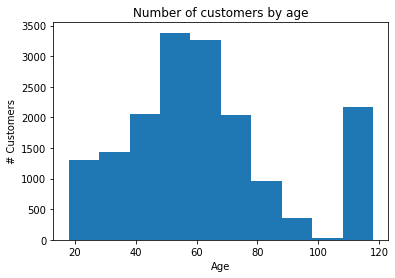

In [13]:
hist_plot(data=profile['age'], title='Number of customers by age', xlabel='Age', ylabel='# Customers')

**As shown in the graph above, most of the customers are between 50 and 70 years old. It is also evident that there are outliers, which would later be targeted for cleaning.**

### Income Description

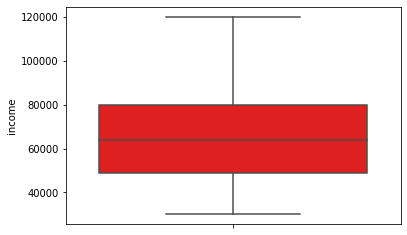

In [14]:
sns.boxplot(y='income', data=profile, color='red')

In [15]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

**It is evident that the income variable does not have atypical data, that the average income of the clients is 65,404, that 50% of the clients have incomes from 49,000 to 80,000 and that 25% of the clients have incomes over 120,000.**

### 2.3 Transcript Data

This database contains records of transactions, bids received, bids viewed and bids completed, the variables are as follows::

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**The following database contains 306,534 records.**

In [16]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
transcript.shape

(306534, 4)

### Null value analysis

In [18]:
print(transcript.isnull().sum())

person    0
event     0
value     0
time      0
dtype: int64


**It is evident that this base does not contain null values.**

### Gender Description

In [19]:
event_counts = transcript.groupby('event')['person'].count()
print(event_counts)
print('# customers =',event_counts.sum())

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64
# customers = 306534


In [20]:
print(event_counts/event_counts.sum())

event
offer completed    0.109544
offer received     0.248837
offer viewed       0.188315
transaction        0.453304
Name: person, dtype: float64


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

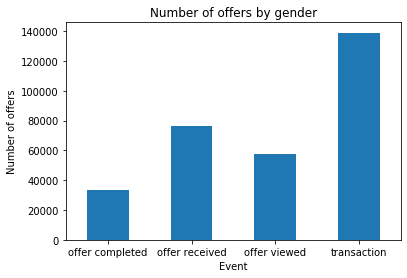

In [21]:
event_counts.plot(kind='bar')
plt.title('Number of offers by gender')
plt.ylabel('Number of offers')
plt.xlabel('Event')
plt.xticks(rotation = 0)

**Shows that 45.3% are transactions, followed by 24.8% offer received, after offer viewed 18.8% and offer completed 10.9%.**

## 3. Methodology


### 3.1 Data Preprocessing

In this section we clean and prepare the data for each database supplied, let's start with the first dataset, 

### Cleaning  Portfolio Dataset

**In the Portfolio dataset, the communication channel variable is pivoted, as well as the type of offer and the latter is united in a single database.**

In [22]:
dataset_port = portfolio.copy()

In [23]:
def clean_portfolio(dataset_1):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    cleaned_portfolio.rename(columns={'id':'offer_id'}, inplace=True)
    
    return cleaned_portfolio

In [24]:
cleaned_portfolio = clean_portfolio(dataset_port)

In [25]:
cleaned_portfolio.head()

,reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


### Cleaning Profile Data

**In the Profile dataset, the atypical data of the variable age, i.e. ages equal to 118, are eliminated and the variable memberdays is transformed into date format.**

In [26]:
dataset_prof = profile.copy()

In [27]:
def clean_profile(dataset_prof):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    cleaned_profile = profile.copy()
    # age: (numeric) missing value encoded as 118
    cleaned_profile['age'] = cleaned_profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    cleaned_profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(cleaned_profile['became_member_on'], format='%Y%m%d').dt.date
    cleaned_profile['memberdays'] = cleaned_profile['memberdays'].dt.days
    cleaned_profile.rename(columns={'id':'customer_id'}, inplace=True)
    
    return cleaned_profile

In [28]:
cleaned_profile = clean_profile(dataset_prof)


In [29]:
cleaned_profile.head()

,gender,age,customer_id,became_member_on,income,memberdays
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1467
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1314
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,952
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1381
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,1294


###  Cleaning Transcript Data

In the Transcript dataset, the rows related to the offer action are extracted, their id and the variables are renamed, in order to subsequently perform the database joins.

In [30]:
dataset_trans = transcript.copy()

In [31]:
def clean_transcript(dataset_trans):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    offer = transcript.copy()
    # extract the rows that are related to offer action 
    offer = offer[offer['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    offer.rename(columns={'person':'customer_id'}, inplace=True)
    
    return offer

In [32]:
offer = clean_transcript(dataset_trans)
offer.head()

,customer_id,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


**After the cleaning process, it is evident how the atypical data of the variable age is already corrected.**

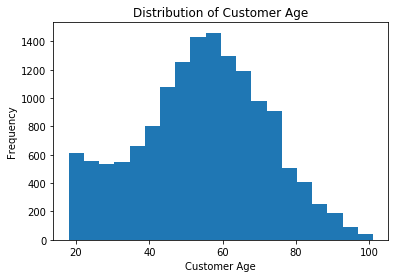

In [33]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # display histogram of customer age
    user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
    user_age.set_xlabel("Customer Age")

# visulize customer profile data
display_customer_profile()

## 3.2 Implementation and Refinement

Next, the three databases are merged together

In [34]:
def merge_datasets(cleaned_portfolio, cleaned_profile, offer):
    """ Merge the three data sets into one
    Input:
    - portfolio_clean
    - profile_clean
    - transcript_clean
    Output:
    - df: merged dataframe
    """
    trans_prof = pd.merge(offer, cleaned_profile, on='customer_id',
                          how="left")
    df = pd.merge(trans_prof, cleaned_portfolio, on='offer_id', how='left')
    # Change the offer ids to a simplied form
    offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'Bogo',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'Bogo',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'Bogo',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'Bogo',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'Discount',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'Discount',
                'fafdcd668e3743c1bb461111dcafc2a4': 'Discount',
                '2906b810c7d4411798c6938adc9daaa5': 'Discount',
                '3f207df678b143eea3cee63160fa8bed': 'Informational',
                '5a8bc65990b245e5a138643cd4eb9837': 'Informational'}
    
    
    
    df.offer_id = df.offer_id.apply(lambda x: offer_id[x] if x else None)

    return df

In [35]:
df = merge_datasets(cleaned_portfolio, cleaned_profile, offer)

In [36]:
df.head()

,customer_id,event,value,time,offer_id,gender,age,became_member_on,income,memberdays,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,Bogo,F,75.0,20170509,100000.0,1381,5,5,7,1,1,1,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,Discount,None,NaN,20170804,NaN,1294,5,20,10,1,1,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,Discount,M,68.0,20180426,70000.0,1029,2,10,7,1,1,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,Discount,None,NaN,20170925,NaN,1242,2,10,10,1,1,1,1,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,Bogo,None,NaN,20171002,NaN,1235,10,10,5,1,1,1,1,1,0,0


## Information analysis

**In order to analyze the best offers by demographic group, we will proceed to perform a cross analysis of two demographic variables vs. the type of offer.**

### Type of offer by _Record description_.

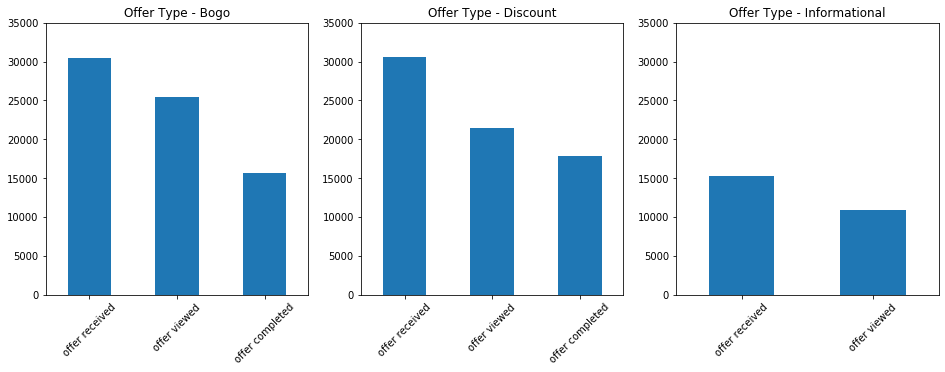

In [37]:
plt.subplot(131)
df[df.bogo == 1].event.value_counts().plot(kind='bar', rot=45, figsize=(16,5))
plt.ylim(0, 35000)
plt.title('Offer Type - Bogo')


plt.subplot(132)
df[df.discount == 1].event.value_counts().plot(kind='bar', rot=45, figsize=(16,5))
plt.ylim(0, 35000)
plt.title('Offer Type - Discount')

plt.subplot(133)
df[df.informational == 1].event.value_counts().plot(kind='bar', rot=45, figsize=(16,5))
plt.ylim(0, 35000)
plt.title('Offer Type - Informational')
plt.savefig('Offer Type.png')

**The above graph shows that the most important offers are Bogo and Discount, and that the most frequently completed offer is Discount.**

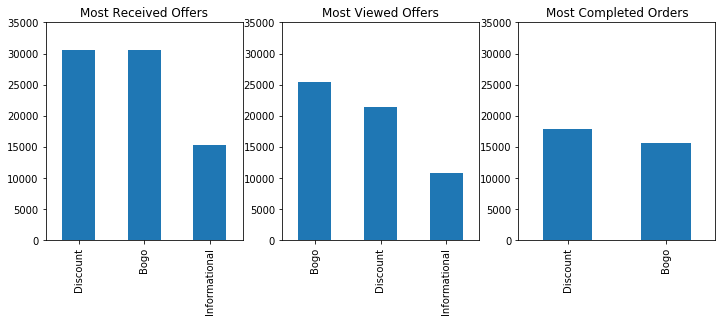

In [38]:
plt.subplot(131)
df[df.event == 'offer received'].offer_id.value_counts().plot(kind='bar', figsize=(12,4))
plt.ylim(0, 35000)
plt.title('Most Received Offers')

plt.subplot(132)
df[df.event == 'offer viewed'].offer_id.value_counts().plot(kind='bar', figsize=(12,4))
plt.ylim(0, 35000)
plt.title('Most Viewed Offers')

plt.subplot(133)
df[df.event == 'offer completed'].offer_id.value_counts().plot(kind='bar', figsize=(12,4))
plt.ylim(0, 35000)
plt.title('Most Completed Orders')
plt.savefig('Offer completed.png')

**The most received offers are Discount and Bogo, the most viewed and completed is Bogo, followed by Discount. From this we conclude that the best offer is Bogo.**

### Type of offer by _Gender_.

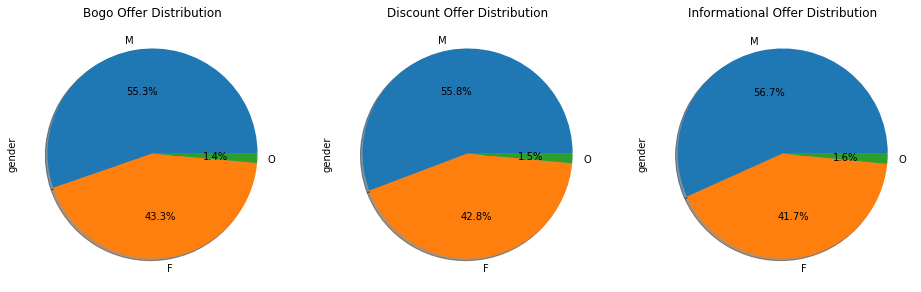

In [39]:
plt.subplot(131)
df[df.bogo == 1].gender.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(16,5))
plt.title('Bogo Offer Distribution')

plt.subplot(132)
df[df.discount == 1].gender.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(16,5))
plt.title('Discount Offer Distribution')

plt.subplot(133)
df[df.informational == 1].gender.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(16,5))
plt.title('Informational Offer Distribution')
plt.savefig('Offer Distribution.png')

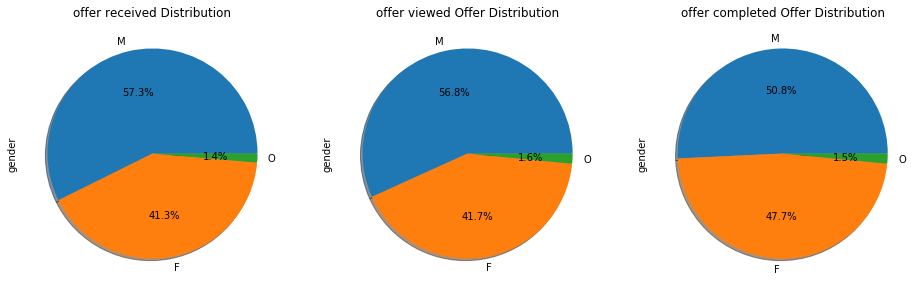

In [40]:
plt.subplot(131)
df[df.event == 'offer received'].gender.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(16,5))
plt.title('offer received Distribution')

plt.subplot(132)
df[df.event == 'offer viewed'].gender.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(16,5))
plt.title('offer viewed Offer Distribution')

plt.subplot(133)
df[df.event == 'offer completed'].gender.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(16,5))
plt.title('offer completed Offer Distribution')
plt.savefig('Offer Distribution.png')

**After reviewing the proportion of gender by type of supply, it is evident that there is no difference by gender, that is to say that gender does not generate a tendency towards one type of supply.**

**It is also observed that in the completed offers there is a slight preference for women.**

### Type of offer by _Income_.

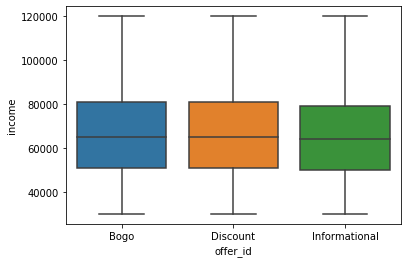

In [41]:
sns.boxplot(x='offer_id', y='income', data=df)

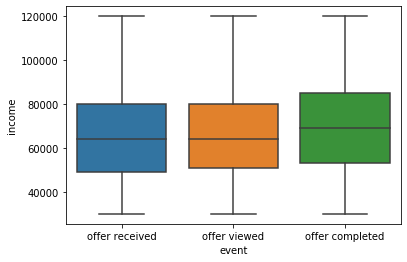

In [42]:
sns.boxplot(x='event', y='income', data=df)

**After reviewing the income of clients by type of offer, it is observed that there are no differences, i.e., that clients earning more or less do not generate a tendency towards one type of offer.**

**It is also observed that in the completed offers there is a slight preference for customers with higher incomes.**

## 4. Results

**Next, we create the pipelines for the data transformation, with the objective of building a solid database to create a logistic regression model.**

In [43]:
datos=pd.get_dummies(df, columns=["event","gender","offer_id"])


In [44]:
datos.head()

,customer_id,value,time,age,became_member_on,income,memberdays,reward,difficulty,duration,...,informational,event_offer completed,event_offer received,event_offer viewed,gender_F,gender_M,gender_O,offer_id_Bogo,offer_id_Discount,offer_id_Informational
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,75.0,20170509,100000.0,1381,5,5,7,...,0,0,1,0,1,0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,20170804,NaN,1294,5,20,10,...,0,0,1,0,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,68.0,20180426,70000.0,1029,2,10,7,...,0,0,1,0,0,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,20170925,NaN,1242,2,10,10,...,0,0,1,0,0,0,0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,20171002,NaN,1235,10,10,5,...,0,0,1,0,0,0,0,1,0,0


**We select only the variables of interest to be studied.**

In [45]:
datos2=datos[['age','gender_F','gender_M','gender_O','offer_id_Bogo','offer_id_Discount','offer_id_Informational','income','difficulty','web','email','mobile','social','event_offer completed']]

In [46]:
datos2.head()

,age,gender_F,gender_M,gender_O,offer_id_Bogo,offer_id_Discount,offer_id_Informational,income,difficulty,web,email,mobile,social,event_offer completed
0,75.0,1,0,0,1,0,0,100000.0,5,1,1,1,0,0
1,NaN,0,0,0,0,1,0,NaN,20,1,1,0,0,0
2,68.0,0,1,0,0,1,0,70000.0,10,1,1,1,0,0
3,NaN,0,0,0,0,1,0,NaN,10,1,1,1,1,0
4,NaN,0,0,0,1,0,0,NaN,10,1,1,1,1,0


**Finally, the null data was deleted, leaving a total of 148,805 records.**

In [47]:
datos3 = pd.DataFrame(datos2.dropna())
datos3.shape
print('(# filas,# Columnas)=', datos3.shape)

(# filas,# Columnas)= (148805, 14)


In [48]:
datos3.head()

,age,gender_F,gender_M,gender_O,offer_id_Bogo,offer_id_Discount,offer_id_Informational,income,difficulty,web,email,mobile,social,event_offer completed
0,75.0,1,0,0,1,0,0,100000.0,5,1,1,1,0,0
2,68.0,0,1,0,0,1,0,70000.0,10,1,1,1,0,0
5,65.0,0,1,0,1,0,0,53000.0,5,1,1,1,1,0
7,58.0,0,1,0,0,0,1,51000.0,0,1,1,1,0,0
8,61.0,1,0,0,0,1,0,57000.0,20,1,1,0,0,0


### Logistic regression model

With the consolidated database, we partition the training base and the test base, 70% and 30% respectively.

In [49]:
# Division of data into train and test
# ==============================================================================
X = datos3[['age','gender_F','gender_M','offer_id_Bogo','offer_id_Discount','income','difficulty','web','email','mobile','social']]
y = datos3['event_offer completed']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.7,
                                        random_state = 1234
                                    )

In [50]:
# Creation of the model using matrices as in scikitlearn
# ==============================================================================
# A column of 1s has to be added to the predictor matrix for the model intercept.
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 35


C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             Logit Regression Results                            
Dep. Variable:     event_offer completed   No. Observations:               104163
Model:                             Logit   Df Residuals:                   104152
Method:                              MLE   Df Model:                           10
Date:                   Thu, 18 Feb 2021   Pseudo R-squ.:                     inf
Time:                           01:31:22   Log-Likelihood:                   -inf
converged:                         False   LL-Null:                        0.0000
Covariance Type:               nonrobust   LLR p-value:                     1.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                   0.0011      0.000      2.218      0.027       0.000       0.002
gender_F              0.0491      0.064      0.768      0.442      -0.076       0.174


C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [51]:
# Probability prediction
# ==============================================================================
predicciones = modelo.predict(exog = X_train)
clasificacion = np.where(predicciones<0.5, 0, 1)

In [52]:
# Accuracy of model test 
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
clasificacion = np.where(predicciones<0.5, 0, 1)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = clasificacion,
            normalize = True
           )
print("")
print(f"The test accuracy is: {100*accuracy}%")


The test accuracy is: 78.09013933067514%


**78% of the cases were well classified by the model.**



With 90% confidence in the study, it is evidenced that the variables that are significantly statistical are: age, male gender, income, web, modile and social.

From here it is evident that:

`*` Older customers are more likely to complete the offer.

`*` Men are less likely to complete the offer.

`*` The more income customers have, the more likely they are to complete the offer.

`*` The higher the minimum required ("difficulty") for spending, the probability of completing the offer decreases.

`*` The Web, Email, Mobile and Social communication channels are not effective so that the probability of completing the offer increases 

## 5. Conclusion

### Reflection

**At the beginning of the project, the databases were analyzed separately, in the first it had the characteristics of the campaigns, in the second the demographic characteristics of the clients and in the third the transactional characteristics of the offers, in order to demonstrate value. atypical and null. Then the data was cleaned and a new base was generated, later descriptive analyzes were carried out in order to know the offers with the greatest influence on customers and finally a model was generated to know what variables influenced the decision that the customer complete offer. As an important result, the following stand out: 1. As evidenced in the descriptive and inferential study of the model, it is observed that the gender variable is significant and that men have a lower probability at the time of completing the offer and 2. As evidenced in The descriptive and inferential study of the model shows that the age variable is significant, and shows that the older they are, the more likely they are to complete the offers.**

### Improvement

**Given that the accuracy criterion is not greater than 80%, it is recommended for future studies to implement different modeling methodologies in order to improve their predictions and the behavior of customers to be identified with greater accuracy. Which methodology is better for modeling this data?** 